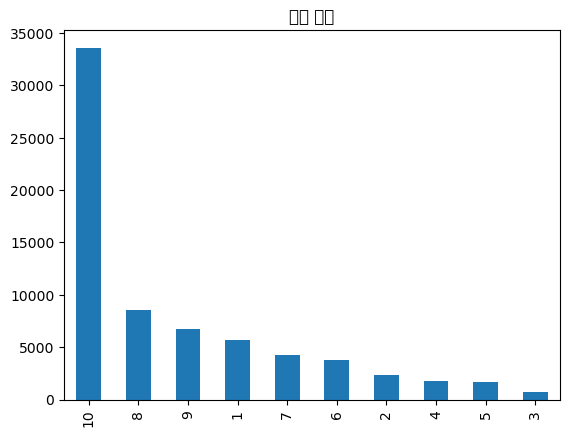

단어 집합의 크기 : 13477
최대 길이 이하인 샘플의 비율 : 87.79977614268152


In [1]:
# 전처리 과정
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 경고 무시
warnings.filterwarnings(action='ignore')

# 데이터 불러오기
df = pd.read_csv("../data/review_rating.csv")

# 중복값 제거
df.drop_duplicates(inplace=True)
len(df)

# 평점 분포 그래프 출력
df['0'].value_counts().plot(kind = 'bar')
plt.title('평점 분포')
plt.show()

# 특수문자,기호 제거
df['1'] = df['1'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")

# 공백 제거
df['1'] = df['1'].str.replace('^ +', "")
df['1'].replace('', np.nan, inplace=True)

# null 샘플 제거
df = df.dropna(how = 'any')

# 불용어 사전
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 데이터를 X, Y로 나누고 학습용, 검증용으로 나누기
y = df['0']
X = df['1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 형태소 분석
okt = Okt(norm=True, stem=True, join=True)
X_train_lis = []
X_test_lis = []
for sentence in X_train:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train_lis.append(temp_X)
for sentence in X_test:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test_lis.append(temp_X)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_lis)
# print(tokenizer.word_index) 

# 출현빈도가 3회 미만인 단어들
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
# print(total_cnt) #단어집합 크기
# print(rare_cnt) #희귀단어수

# 단어 집합의 크기
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

# 텍스트를 숫자 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train_lis) 
X_train = tokenizer.texts_to_sequences(X_train_lis)
X_test = tokenizer.texts_to_sequences(X_test_lis)

# 종속변수를 array로 변환
y_train = np.array(y_train)
y_test = np.array(y_test)

# 리뷰의 최대 길이
max_len=max(len(l) for l in X_train)

#최대 길이 이하인 샘플의 비율
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
print("최대 길이 이하인 샘플의 비율 :", (cnt / len(X_train))*100)

# 독립변수 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# 모델 생성하는 함수
def create_model(optimizer="rmsprop"):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length = max_len))
    model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu', strides = 1))
    model.add(Conv1D(filters = 32, kernel_size = 4, padding = 'same',activation = 'relu', strides = 1))
    model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same',activation = 'relu', strides = 1))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics=['mse'])
    return model

# 모델 생성
neural_network = KerasClassifier(model=create_model, verbose=0)

#  하이퍼파라미터 탐색 영역을 정의
pipe=Pipeline([
    ('clf', neural_network)
    ])
params={
    'clf__epochs': [10, 15],
    'clf__batch_size': [32,64,128],
    'clf__optimizer': ["rmsprop", "adam"],
    }

# 파라미터 검색
grid=GridSearchCV(pipe, params, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)

# 결과 출력
print(grid_result.best_params_)
print(grid_result.best_score_)

In [5]:
# 최적의 파라미터로 모델 마무리
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_len))
model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 64, kernel_size = 4, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 16, kernel_size = 2, padding = 'same',activation = 'relu', strides = 1))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(loss = 'mse', optimizer = 'rmsprop', metrics=['mse'])
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint('../model/review_CNN.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size = 32, epochs=10, validation_split=0.2, callbacks=[es, mc])

# 모델 평가
loaded_model = load_model('../model/review_CNN.h5')
loaded_model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 211, 100)          1347700   
                                                                 
 conv1d_3 (Conv1D)           (None, 211, 128)          64128     
                                                                 
 conv1d_4 (Conv1D)           (None, 211, 64)           32832     
                                                                 
 conv1d_5 (Conv1D)           (None, 211, 32)           6176      
                                                                 
 conv1d_6 (Conv1D)           (None, 211, 16)           1040      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 42, 16)           0         
 1D)                                                             
                                                      

[4.729007720947266, 4.729007720947266]

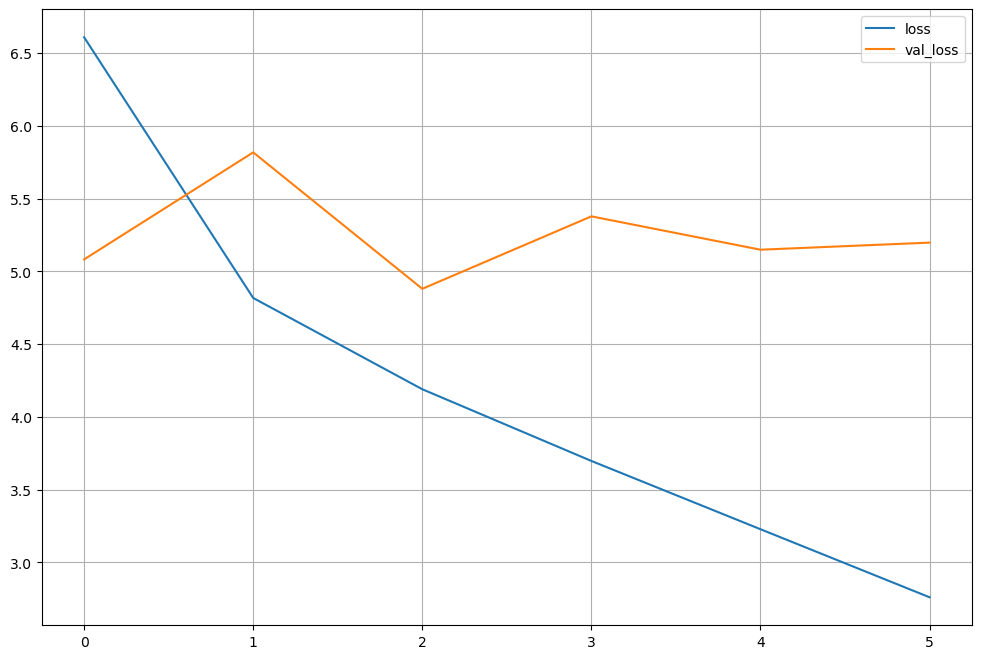

In [6]:
# 모델 학습 과정 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) #손실
plt.plot(hist.history['val_loss']) #validation 손실
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()